In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vwjaghty
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vwjaghty
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [2]:
import os
import cv2
import numpy as np 
import pandas as pd 
import json
import csv
import torch
import clip
import pickle
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from collections import Counter
from transformers import BertTokenizer
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
KAGGLE_PATH = "/kaggle/input/vizwiz/data/"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clipModel, preprocess = clip.load("ViT-B/32", device=device)

In [5]:
def load_data(input):
    with open(input, 'r') as f:
        data = json.load(f)
    return data    

In [6]:
# method to read an image and transform it into a numpy array
def read_image(img_name):
    img = Image.open(os.path.join(KAGGLE_PATH, "Images/", img_name))
    imgArr = np.array(img) 
    img.close()
    return imgArr

In [7]:
def find_most_common_element(arr):
    counter = Counter(arr)
    most_common = counter.most_common(1)
    return most_common[0][0] if most_common else None

In [8]:
def split_data(dataset):
    answerable, combined_features, answer_type, answers = [], [], [], []
    for item in dataset:
        # extract answerable
        answerable.append(item['answerable'])
        # extract image
        imgPath = os.path.join(KAGGLE_PATH, "Images/", item['image'])
        image_input = preprocess(Image.open(imgPath)).unsqueeze(0).to(device)
        # extract question
        question_inputs = clip.tokenize(item['question']).to(device)
        # encode data
        with torch.no_grad():
            image_input = clipModel.encode_image(image_input)
            question_inputs = clipModel.encode_text(question_inputs) 
        # normalize data
        image_input /= image_input.norm(dim=-1, keepdim=True)
        question_inputs /= question_inputs.norm(dim=-1, keepdim=True)
        # combine them
        combined_features.append(torch.cat((question_inputs, image_input), dim=1))
        # extract answer type
        answer_type.append([item['answer_type']])
        # get all answers
        ans = [item['answers'][i]['answer'] for i in range(len(item['answers']))]
        # take the most common answer
        answers.append(find_most_common_element(ans))
    return answerable, combined_features, answer_type, answers

In [9]:
dataset = load_data(os.path.join(KAGGLE_PATH, 'Annotations/train.json')) 

In [10]:
#answerable, combined_features, answer_type, answers = split_data(dataset)

In [11]:
'''
# saving the output for later use
file_name = 'combined_features.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(answerable, file)
    print(f'answerable successfully saved to "{file_name}"')
    pickle.dump(combined_features, file)
    print(f'combined_features successfully saved to "{file_name}"')
    pickle.dump(answer_type, file)
    print(f'answer_type successfully saved to "{file_name}"')
    pickle.dump(answers, file)
    print(f'answers successfully saved to "{file_name}"')
'''

'\n# saving the output for later use\nfile_name = \'combined_features.pkl\'\nwith open(file_name, \'wb\') as file:\n    pickle.dump(answerable, file)\n    print(f\'answerable successfully saved to "{file_name}"\')\n    pickle.dump(combined_features, file)\n    print(f\'combined_features successfully saved to "{file_name}"\')\n    pickle.dump(answer_type, file)\n    print(f\'answer_type successfully saved to "{file_name}"\')\n    pickle.dump(answers, file)\n    print(f\'answers successfully saved to "{file_name}"\')\n'

In [12]:
file_name = '/kaggle/input/combined-features/combined_features.pkl'
with open(file_name, 'rb') as file:
    answerable  = pickle.load(file)
    print(f'answerable successfully loaded from "{file_name}"')
    combined_features  = pickle.load(file)
    print(f'combined_features successfully loaded from "{file_name}"')
    answer_type  = pickle.load(file)
    print(f'answer_type successfully loaded from "{file_name}"')
    answers  = pickle.load(file)
    print(f'answers successfully loaded from "{file_name}"')

answerable successfully loaded from "/kaggle/input/combined-features/combined_features.pkl"
combined_features successfully loaded from "/kaggle/input/combined-features/combined_features.pkl"
answer_type successfully loaded from "/kaggle/input/combined-features/combined_features.pkl"
answers successfully loaded from "/kaggle/input/combined-features/combined_features.pkl"


In [13]:
# one hot encoding on Y
encoder = OneHotEncoder(sparse_output=False)
Y_OHE = encoder.fit_transform(np.array(answers).reshape(-1, 1))
Y_OHE.shape

(20000, 5507)

In [14]:
# one hot encoding on Yt
auxencoder = OneHotEncoder(sparse_output=False)
Yt_OHE = auxencoder.fit_transform(np.array(answer_type).reshape(-1, 1))
Yt_OHE.shape

(20000, 4)

In [15]:
# one hot encoding on Yt
aencoder = OneHotEncoder(sparse_output=False)
Ya_OHE = aencoder.fit_transform(np.array(answerable).reshape(-1, 1))
Ya_OHE.shape

(20000, 2)

In [16]:
mask1 = np.zeros((5507))
mask2 = np.zeros((5507))
mask3 = np.zeros((5507))
mask4 = np.zeros((5507))
for i in range(20000):
    if (answer_type[i] == ['other']):
        mask1 += Y_OHE[i]
    elif(answer_type[i] == ['number']):
        mask2 += Y_OHE[i]
    elif(answer_type[i] == ['unanswerable']):
        mask3 += Y_OHE[i]
    elif(answer_type[i] == ['yes/no']):
        mask4 += Y_OHE[i]
        
mask1 = mask1 > 0
mask2 = mask2 > 0
mask3 = mask3 > 0
mask4 = mask4 > 0

{dataset[0]['question']
0 {'answer_confidence': 'yes', 'answer': 'basil leaves'}
1 {'answer_confidence': 'yes', 'answer': 'basil leaves'}
2 {'answer_confidence': 'yes', 'answer': 'basil'}
3 {'answer_confidence': 'yes', 'answer': 'basil'}
4 {'answer_confidence': 'yes', 'answer': 'basil leaves'}
5 {'answer_confidence': 'yes', 'answer': 'basil leaves'}
6 {'answer_confidence': 'yes', 'answer': 'basil leaves'}
7 {'answer_confidence': 'yes', 'answer': 'basil leaves'}
8 {'answer_confidence': 'yes', 'answer': 'basil leaves'}
9 {'answer_confidence': 'yes', 'answer': 'basil'}


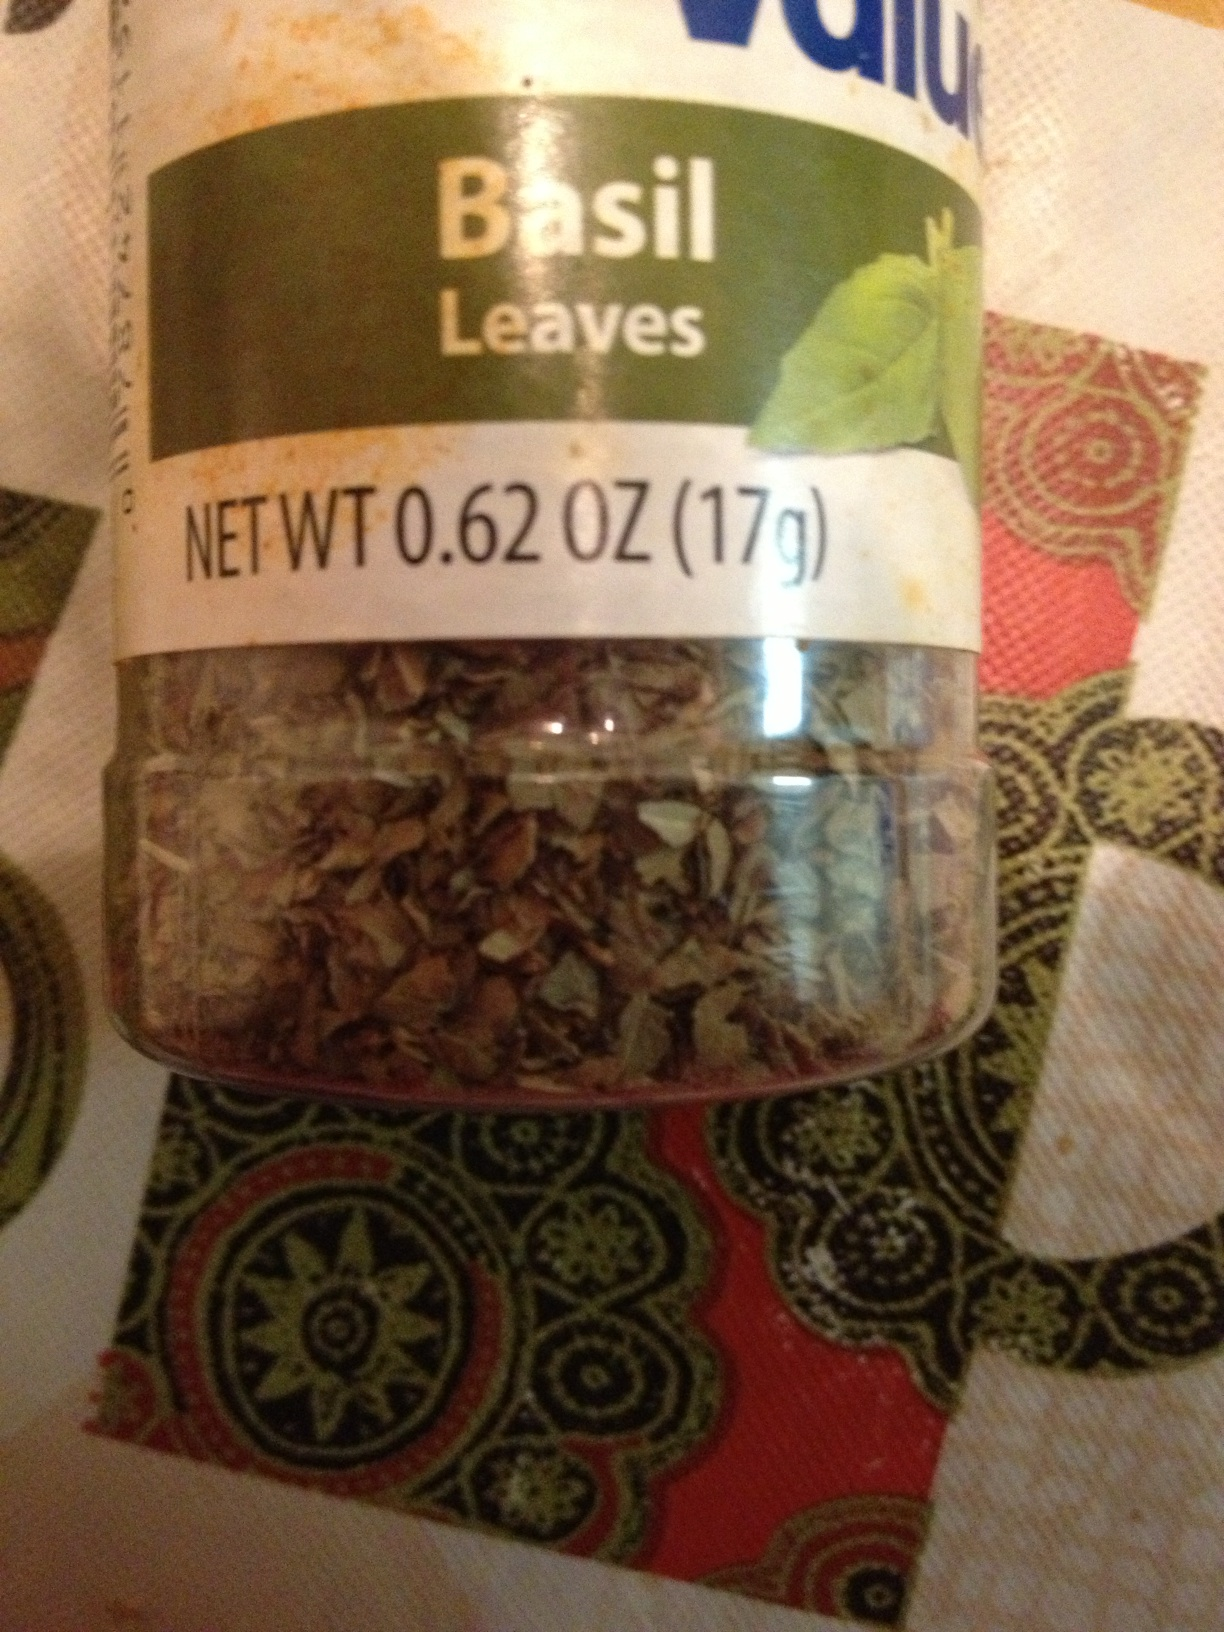

In [17]:
print("{dataset[0]['question']")
for (i, ans) in enumerate(dataset[0]['answers']): print(i, ans)
Image.open(os.path.join(KAGGLE_PATH, "Images/", dataset[0]['image']))

In [18]:
def constructmask(auxout):
    mask = np.zeros((auxout.shape[0],5507))
    auxout = auxencoder.inverse_transform(auxout.cpu().detach().numpy())
    for i in range(auxout.shape[0]):
        if (auxout[i] == ['other']):
            mask[i] += mask1
        elif(auxout[i] == ['number']):
            mask[i] += mask2
        elif(auxout[i] == ['unanswerable']):
            mask[i] += mask3
        elif(auxout[i] == ['yes/no']):
            mask[i] += mask4
    return torch.from_numpy(mask)

In [19]:
class myDataset(Dataset):
    def __init__(self, answerable, combined_features, answer_type, answers):
        # save data
        self.answerable = answerable
        self.combined_features = combined_features
        self.answer_type = answer_type
        self.answers = answers

    def __getitem__(self, index):
        # retrieve data
        answerable = self.answerable[index]
        combined_features = self.combined_features[index]
        answer_type_inputs = self.answer_type[index]
        answer = self.answers[index]
        
        return (torch.tensor(answerable), combined_features, 
                torch.tensor(answer_type_inputs), torch.tensor(answer))

    def __len__(self):
        return len(self.answerable)

In [20]:
# defining our model
class VQAModel(nn.Module):
    def __init__(self, num_classes):
        super(VQAModel, self).__init__()
        self.normalize = nn.LayerNorm(1024)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU()
        self.fca = nn.Linear(256, 2)
        self.fcaux = nn.Linear(256, 4)
        self.fcans = nn.Linear(256, num_classes)

    def forward(self, combined_features):
        normalized = self.normalize(combined_features)
        droppedOut = self.dropout(normalized)
        output = self.fc1(droppedOut)
        output = self.relu(output)
        # fully connected layers
        aout = self.fca(output)
        auxout = self.fcaux(output)
        ansout = self.fcans(output)
        return (aout, ansout, auxout)

In [21]:
# defining the training parameters
batch_size = 128
learning_rate = 0.001
num_epochs = 500

customDataset = myDataset(Ya_OHE, combined_features, Yt_OHE, Y_OHE)
# split the list into training and testing sets
train_data, val_data = train_test_split(customDataset, train_size=0.95, stratify=Yt_OHE, random_state=42)

# creating training and validation data loaders
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_data_loader = DataLoader(val_data, batch_size=batch_size)

# creating an instance of our model
model = VQAModel(num_classes=len(Y_OHE[0]))
model.to(device)

# defining the loss function
criterion = nn.CrossEntropyLoss()
acriterion = nn.CrossEntropyLoss()
auxcriterion = nn.CrossEntropyLoss()

# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [22]:
def run_model(model, train_dataloader, val_dataloader, optimizer):
    # training phase
    model.train()
    atrain_loss, auxtrain_loss, train_loss = 0.0, 0.0, 0.0
    for (answerable, combined_features, answer_type, answers) in train_dataloader:
        combined_features = combined_features.squeeze(1).to(device)
        answers = answers.to(device)
        answer_type = answer_type.to(device)
        optimizer.zero_grad()
        # forward pass
        (aout, outputs, auxout) = model(combined_features)
        # remove extra dimension
        aout = aout.squeeze(1)
        outputs = outputs.squeeze(1)
        auxout = auxout.squeeze(1)
        # calculate aux loss
        aloss = acriterion(aout, answerable)
        auxloss = auxcriterion(auxout, answer_type)
        # construct mask
        mask = constructmask(auxout)
        # mask the output
        outputs = outputs * mask
        # compute answer loss
        loss = criterion(outputs, answers)
        total_loss = loss + auxloss + aloss
        # backward pass and optimization
        total_loss.backward()
        optimizer.step()
        # compute loss
        atrain_loss += aloss.item()
        auxtrain_loss += auxloss.item()
        train_loss += loss.item()
    atrain_loss /= len(train_dataloader)
    auxtrain_loss /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    
    # validation phase
    model.eval()
    aval_loss, auxval_loss, val_loss, accuracy = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():    
        for (answerable, combined_features, answer_type, answers) in val_data_loader:
            combined_features = combined_features.squeeze(1).to(device)
            answers = answers.to(device)
            answer_type = answer_type.to(device)
            # forward pass
            (aout, outputs, auxout) = model(combined_features)
            # remove extra dimension
            aout = aout.squeeze(1)
            outputs = outputs.squeeze(1)
            auxout = auxout.squeeze(1)
            # construct mask
            mask = constructmask(auxout)
            # mask the output
            outputs = outputs * mask
            # compute answer loss
            aloss = acriterion(aout, answerable)
            auxloss = auxcriterion(auxout, answer_type)
            loss = criterion(outputs, answers)
            # compute loss
            aval_loss += (aloss.item())
            auxval_loss += (auxloss.item())
            val_loss += (loss.item())
            # calculate accuracy
            accuracy += (torch.argmax(answers, dim=1) == torch.argmax(outputs, dim=1)).sum()
        aval_loss /= len(val_data_loader)
        auxval_loss /= len(val_data_loader)
        val_loss /= len(val_data_loader)
        accuracy /= len(val_data_loader)
    return atrain_loss, auxtrain_loss, train_loss, aval_loss, auxval_loss, val_loss, accuracy

In [23]:
# computing loss
atrain_loss_arr, auxtrain_loss_arr, train_loss_arr = [], [], [] 
aval_loss_arr, auxval_loss_arr, val_loss_arr, accuracy_arr = [], [], [], []

Epoch 0/500 atrainLoss: 0.45563943925400596, auxtrainLoss: 0.7008712516826782, trainLoss: 5.899176865703665
Epoch 0/500 avalLoss:   0.39867223047303924, auxvalLoss: 0.6159022842967505, valLoss: 5.473205330179025
Validation Accuracy: 33.625
Epoch 10/500 atrainLoss: 0.35054085901924636, auxtrainLoss: 0.49495010315198246, trainLoss: 3.012184642338046
Epoch 10/500 avalLoss:   0.3673107649455781, auxvalLoss: 0.550182891126103, valLoss: 4.706721626064568
Validation Accuracy: 42.375
Epoch 20/500 atrainLoss: 0.31003179856512203, auxtrainLoss: 0.42704137615453436, trainLoss: 1.969302765055717
Epoch 20/500 avalLoss:   0.377924583218493, auxvalLoss: 0.5759378582576153, valLoss: 4.819176917443221
Validation Accuracy: 42.125
Epoch 30/500 atrainLoss: 0.2921402485745308, auxtrainLoss: 0.395325510696197, trainLoss: 1.6637845183961018
Epoch 30/500 avalLoss:   0.3848690517847078, auxvalLoss: 0.6058865000797383, valLoss: 4.887908591781823
Validation Accuracy: 41.0
Epoch 40/500 atrainLoss: 0.2754527659356

KeyboardInterrupt: 

In [71]:
for g in optimizer.param_groups:
    g['lr'] = 1e-07

In [72]:
for g in optimizer.param_groups:
    print(g['lr'])

1e-07


In [73]:
for epoch in range(num_epochs+1):
    atrain_loss, auxtrain_loss, train_loss, aval_loss, auxval_loss, val_loss, accuracy = run_model(model, train_data_loader, val_data_loader, optimizer)
    atrain_loss_arr.append(atrain_loss)
    auxtrain_loss_arr.append(auxtrain_loss)
    train_loss_arr.append(train_loss)
    aval_loss_arr.append(aval_loss)
    auxval_loss_arr.append(auxval_loss)
    val_loss_arr.append(val_loss)
    accuracy_arr.append(accuracy)
    if (epoch % 10) == 0: 
        print(f"Epoch {epoch}/{num_epochs} atrainLoss: {atrain_loss}, auxtrainLoss: {auxtrain_loss}, trainLoss: {train_loss}")
        print(f"Epoch {epoch}/{num_epochs} avalLoss:   {aval_loss}, auxvalLoss: {auxval_loss}, valLoss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")

Epoch 0/500 atrainLoss: 0.25251674702442944, auxtrainLoss: 0.35681145001547715, trainLoss: 2.8689738794407353
Epoch 0/500 avalLoss:   0.373978866505051, auxvalLoss: 0.5594568314465851, valLoss: 4.612330787390509
Validation Accuracy: 41.875
Epoch 10/500 atrainLoss: 0.2505560962775106, auxtrainLoss: 0.36004279376558707, trainLoss: 2.873638131695011
Epoch 10/500 avalLoss:   0.3738031550891448, auxvalLoss: 0.5593209560724753, valLoss: 4.614937391850301
Validation Accuracy: 41.875
Epoch 20/500 atrainLoss: 0.251905181919818, auxtrainLoss: 0.3564148524483733, trainLoss: 2.8781391744004896
Epoch 20/500 avalLoss:   0.3736848829028415, auxvalLoss: 0.5592124187735976, valLoss: 4.617246733285294
Validation Accuracy: 41.75
Epoch 30/500 atrainLoss: 0.24933818680367817, auxtrainLoss: 0.3574228134137374, trainLoss: 2.8995145366155577
Epoch 30/500 avalLoss:   0.3735753244282012, auxvalLoss: 0.5590987765410292, valLoss: 4.619459017922772
Validation Accuracy: 41.75
Epoch 40/500 atrainLoss: 0.251141387064

KeyboardInterrupt: 

## Plotting loss & Accuracy

In [ ]:
x_axis = [i for i in range(num_epochs+1)]
subplot_titles = ["Answerability Loss", "Answer Type Loss", "Answer Loss"]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(x_axis, accuracy_arr);

In [ ]:
def plot(x, Y, num_columns, title, subplot_titles):
    fig, axis = plt.subplots(1, num_columns, figsize=(12, 6))
    fig.subplots_adjust(wspace=0.5)
    for j in range(num_columns):
        axis[j].plot(x, Y[j])
        axis[j].set_title(subplot_titles[j])
    fig.suptitle(title)

In [ ]:
title = "Training Data Loss"
Y = [atrain_loss_arr, auxtrain_loss_arr, train_loss_arr]
plot(x_axis, Y, 3, title, subplot_titles)

In [ ]:
title = "Validation Data Loss"
Y = [aval_loss_arr, auxval_loss_arr, val_loss_arr]
plot(x_axis, Y, 3, title, subplot_titles)

In [ ]:
def model_predict(imgpath, question):
    arr = cv2.imread(imgpath)
    plt.imshow(np.array(arr));
    image_input = preprocess(Image.open(imgpath)).unsqueeze(0).to(device)
    question_inputs = clip.tokenize(question).to(device)
    # encode data
    with torch.no_grad():
        image_input = clipModel.encode_image(image_input)
        question_inputs = clipModel.encode_text(question_inputs)

    # normalize data
    image_input /= image_input.norm(dim=-1, keepdim=True)
    question_inputs /= question_inputs.norm(dim=-1, keepdim=True)

    # combine them
    combined_features = torch.cat((question_inputs, image_input), dim=1)

    # Forward pass
    (aout, outputs, auxout) = model(combined_features)
    outputs = outputs.squeeze(1)
    auxout = auxout.squeeze(1)

    mask = constructmask(auxout)

    outputs = outputs*mask

    y_pred = encoder.inverse_transform(outputs.detach().numpy())
    print(y_pred[0][0])

In [ ]:
question = "What is this?"
imgpath = "/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020015.jpg"
model_predict(imgpath, question)

In [ ]:
question = "What is this?"
imgpath = "/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020016.jpg"
model_predict(imgpath, question)